Export Controlled: ECCN EAR1E998

Warning: This document contains technical data whose export is restricted by the Bureau of Industry & Security’s Export Administration Regulations and cannot be exported or re-exported without the authorization of the U.S. government. Violations of these export laws are subject to severe criminal penalties. Diversion contrary to U.S. law is prohibited.

Start with:

Zone temperature, CO2, damper position, flow rate input

Objective:

anomaly detection aligned with different sensors

# Single VAV analysis using different kinds of sensors

(Zone temperature, CO2, damper position, flow rate input)

In [4]:
import pandas as pd
pd.set_option('max_rows', 200)
pd.set_option('max_columns', 200)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import altair as alt
alt.renderers.enable('notebook')

import pickle
import seaborn as sns

from UTCDAL.Design.AnomalyDetection import UnsupervisedAD, select_kbest, normalize
from UTCDAL.Design.TimeseriesAnalysis import extract_features, features

In [2]:
raw_temp = pd.read_csv('./VAV_whole_year/utrc_vav-1-2@lstat.zip', index_col=0, parse_dates=True)
raw_co2 = pd.read_csv('./VAV_whole_year/utrc_vav-1-2@zone_co2.zip', index_col=0, parse_dates=True)
raw_dmpr = pd.read_csv('./VAV_whole_year/utrc_vav-1-2@dmpr_pos_tn.zip', index_col=0, parse_dates=True)
raw_flow = pd.read_csv('./VAV_whole_year/utrc_vav-1-2@air_flow@flow_input.zip', index_col=0, parse_dates=True)

raw_temp.columns = ['zone_temp']
raw_co2.columns = ['co2']
raw_dmpr.columns = ['damper_position']
raw_flow.columns = ['flow_rate']

In [5]:
raw_temp.head(3)

,zone_temp
2017-01-01 00:00:00,71.0
2017-01-01 00:01:00,71.0
2017-01-01 00:02:00,71.0


In [6]:
raw_co2.head(3)

,co2
2017-01-01 00:00:00,370.0
2017-01-01 00:01:00,375.0
2017-01-01 00:02:00,373.0


In [7]:
raw_dmpr.head(3)

,damper_position
2017-01-01 00:00:00,0.0
2017-01-01 00:01:00,0.0
2017-01-01 00:02:00,0.0


In [8]:
raw_flow.head(3)

,flow_rate
2017-01-01 00:00:00,1.0
2017-01-01 00:01:00,1.0
2017-01-01 00:02:00,1.0


In [9]:
def resample(df, freq):
    resamp = df.resample(freq).mean()
    return resamp, resamp.dropna()

In [10]:
def add_date_as_ID(*dfs):
    for df in dfs:
        if 'ID' in df.columns:
            print("'ID' is already a column of the DataFrame.")
        else:
            df['ID'] = [d.strftime('%Y-%m-%d') for d in df.index]

In [11]:
df_temp0, df_temp = resample(raw_temp, '1min')
df_co20, df_co2 = resample(raw_co2, '1min')
df_dmpr0, df_dmpr = resample(raw_dmpr, '1min')
df_flow0, df_flow = resample(raw_flow, '1min')

In [12]:
add_date_as_ID(raw_temp, raw_co2, raw_dmpr, raw_flow)
add_date_as_ID(df_temp0, df_temp)
add_date_as_ID(df_co20, df_co2)
add_date_as_ID(df_dmpr0, df_dmpr)
add_date_as_ID(df_flow0, df_flow)

C:\Users\zhouhait\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
df_temp0.head()

,zone_temp,ID
2017-01-01 00:00:00,71.0,2017-01-01
2017-01-01 00:01:00,71.0,2017-01-01
2017-01-01 00:02:00,71.0,2017-01-01
2017-01-01 00:03:00,71.0,2017-01-01
2017-01-01 00:04:00,70.9,2017-01-01


generate features for eack kind of data. We have prepared before hand, or you can also run the following code to regenerate features

In [14]:
if 0:
    ft_temp = extract_features(df_temp, features)
    ft_co2 = extract_features(df_co2, features)
    ft_dmpr = extract_features(df_dmpr, features)
    ft_flow = extract_features(df_flow, features)

    sensor_features = [ft_temp, ft_co2, ft_dmpr, ft_flow]
    with open('./cached_data/sensor_features.pkl', 'wb') as f:
        pickle.dump(sensor_features, f)

In [16]:
with open('sensor_features.pkl', 'rb') as f:
    ft_temp, ft_co2, ft_dmpr, ft_flow = pickle.load(f)

In [17]:
ft_temp.head(3)

,abs_energy,absolute_sum_of_changes,agg_autocorrelation__var,agg_autocorrelation__mean,agg_autocorrelation__median,partial_autocorrelation__0,partial_autocorrelation__1,partial_autocorrelation__2,partial_autocorrelation__3,partial_autocorrelation__4,partial_autocorrelation__5,partial_autocorrelation__6,partial_autocorrelation__7,partial_autocorrelation__8,partial_autocorrelation__9,min,max,mean,median,var,skewness,burstiness,burstiness_kim,spread_std,spread_iqr,spread_mad,coefficient_var_1,coefficient_var_2,coefficient_var_3,skewness_pearson,skewness_bowley,highlowmu,unique_ratio,change_quantiles__ql_0.0__qh_0.2__isabs_False__f_agg_mean,change_quantiles__ql_0.0__qh_0.2__isabs_False__f_agg_var,change_quantiles__ql_0.0__qh_0.2__isabs_True__f_agg_mean,change_quantiles__ql_0.0__qh_0.2__isabs_True__f_agg_var,change_quantiles__ql_0.0__qh_0.4__isabs_False__f_agg_mean,change_quantiles__ql_0.0__qh_0.4__isabs_False__f_agg_var,change_quantiles__ql_0.0__qh_0.4__isabs_True__f_agg_mean,change_quantiles__ql_0.0__qh_0.4__isabs_True__f_agg_var,change_quantiles__ql_0.0__qh_0.6__isabs_False__f_agg_mean,change_quantiles__ql_0.0__qh_0.6__isabs_False__f_agg_var,change_quantiles__ql_0.0__qh_0.6__isabs_True__f_agg_mean,change_quantiles__ql_0.0__qh_0.6__isabs_True__f_agg_var,change_quantiles__ql_0.0__qh_0.8__isabs_False__f_agg_mean,change_quantiles__ql_0.0__qh_0.8__isabs_False__f_agg_var,change_quantiles__ql_0.0__qh_0.8__isabs_True__f_agg_mean,change_quantiles__ql_0.0__qh_0.8__isabs_True__f_agg_var,change_quantiles__ql_0.0__qh_1.0__isabs_False__f_agg_mean,change_quantiles__ql_0.0__qh_1.0__isabs_False__f_agg_var,change_quantiles__ql_0.0__qh_1.0__isabs_True__f_agg_mean,change_quantiles__ql_0.0__qh_1.0__isabs_True__f_agg_var,change_quantiles__ql_0.2__qh_0.4__isabs_False__f_agg_mean,change_quantiles__ql_0.2__qh_0.4__isabs_False__f_agg_var,change_quantiles__ql_0.2__qh_0.4__isabs_True__f_agg_mean,change_quantiles__ql_0.2__qh_0.4__isabs_True__f_agg_var,change_quantiles__ql_0.2__qh_0.6__isabs_False__f_agg_mean,change_quantiles__ql_0.2__qh_0.6__isabs_False__f_agg_var,change_quantiles__ql_0.2__qh_0.6__isabs_True__f_agg_mean,change_quantiles__ql_0.2__qh_0.6__isabs_True__f_agg_var,change_quantiles__ql_0.2__qh_0.8__isabs_False__f_agg_mean,change_quantiles__ql_0.2__qh_0.8__isabs_False__f_agg_var,change_quantiles__ql_0.2__qh_0.8__isabs_True__f_agg_mean,change_quantiles__ql_0.2__qh_0.8__isabs_True__f_agg_var,change_quantiles__ql_0.2__qh_1.0__isabs_False__f_agg_mean,change_quantiles__ql_0.2__qh_1.0__isabs_False__f_agg_var,change_quantiles__ql_0.2__qh_1.0__isabs_True__f_agg_mean,change_quantiles__ql_0.2__qh_1.0__isabs_True__f_agg_var,change_quantiles__ql_0.4__qh_0.6__isabs_False__f_agg_mean,change_quantiles__ql_0.4__qh_0.6__isabs_False__f_agg_var,change_quantiles__ql_0.4__qh_0.6__isabs_True__f_agg_mean,change_quantiles__ql_0.4__qh_0.6__isabs_True__f_agg_var,change_quantiles__ql_0.4__qh_0.8__isabs_False__f_agg_mean,change_quantiles__ql_0.4__qh_0.8__isabs_False__f_agg_var,change_quantiles__ql_0.4__qh_0.8__isabs_True__f_agg_mean,change_quantiles__ql_0.4__qh_0.8__isabs_True__f_agg_var,change_quantiles__ql_0.4__qh_1.0__isabs_False__f_agg_mean,change_quantiles__ql_0.4__qh_1.0__isabs_False__f_agg_var,change_quantiles__ql_0.4__qh_1.0__isabs_True__f_agg_mean,change_quantiles__ql_0.4__qh_1.0__isabs_True__f_agg_var,change_quantiles__ql_0.6__qh_0.8__isabs_False__f_agg_mean,change_quantiles__ql_0.6__qh_0.8__isabs_False__f_agg_var,change_quantiles__ql_0.6__qh_0.8__isabs_True__f_agg_mean,change_quantiles__ql_0.6__qh_0.8__isabs_True__f_agg_var,change_quantiles__ql_0.6__qh_1.0__isabs_False__f_agg_mean,change_quantiles__ql_0.6__qh_1.0__isabs_False__f_agg_var,change_quantiles__ql_0.6__qh_1.0__isabs_True__f_agg_mean,change_quantiles__ql_0.6__qh_1.0__isabs_True__f_agg_var,change_quantiles__ql_0.8__qh_1.0__isabs_False__f_agg_mean,change_quantiles__ql_0.8__qh_1.0__isabs_False__f_agg_var,change_quantiles__ql_0.8__qh_1.0__isabs_True__f_agg_mean,change_quantiles__ql_0.8__qh_1.0__isabs_True__f_a

In [18]:
def process_features(ftr):
    ftr.replace([np.nan, np.inf, -np.inf], 0, inplace=True)
    return select_kbest(normalize(ftr)[0], 100)

In [19]:
ft_temp1 = process_features(ft_temp)
ft_co21 = process_features(ft_co2)
ft_dmpr1 = process_features(ft_dmpr)
ft_flow1 = process_features(ft_flow)

Train models using different models

In [20]:
ad_temp = UnsupervisedAD()
ad_co2 = UnsupervisedAD()
ad_dmpr = UnsupervisedAD()
ad_flow = UnsupervisedAD()

In [21]:
ad_temp.fit(ft_temp1)
ad_co2.fit(ft_co21)
ad_dmpr.fit(ft_dmpr1)
ad_flow.fit(ft_flow1)

IForest(bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [25]:
score_temp = ad_temp.anomaly_score(ft_temp1)
score_co2 = ad_co2.anomaly_score(ft_co21)
score_dmpr = ad_dmpr.anomaly_score(ft_dmpr1)
score_flow = ad_flow.anomaly_score(ft_flow1)

In [26]:
scores = pd.DataFrame({'Zone temp': score_temp,
                       'CO2': score_co2,
                       'Damper position': score_dmpr,
                       'Flow rate': score_flow}, index=ft_temp1.index)

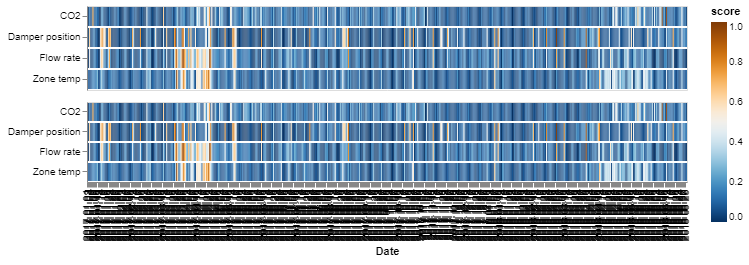

In [27]:
ad_temp.iplot_heatmap_anomaly(scores, ft_temp1.index)

Correlation analysis

In [28]:
scores.corr()

,Zone temp,CO2,Damper position,Flow rate
Zone temp,1.000000,0.421555,0.372310,0.612727
CO2,0.421555,1.000000,0.104500,0.205429
Damper position,0.372310,0.104500,1.000000,0.688634
Flow rate,0.612727,0.205429,0.688634,1.000000


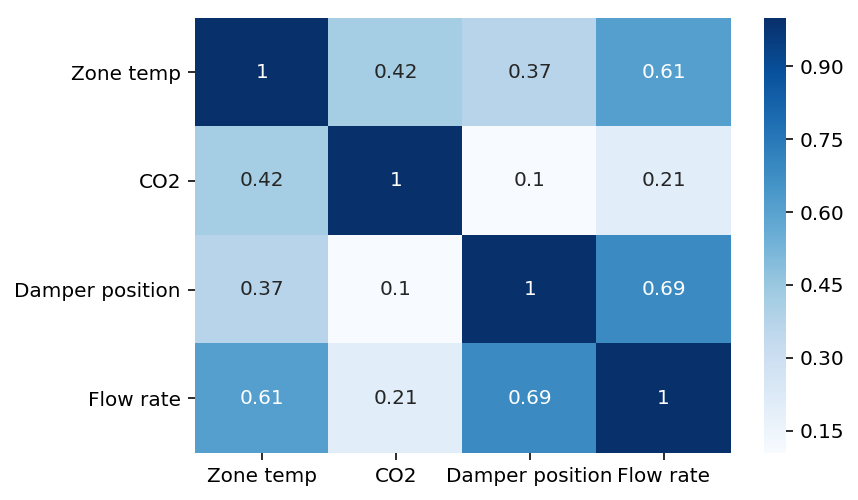

In [29]:
sns.heatmap(scores.corr(), annot=True, cmap='Blues')